In [1]:
import pandas as pd
import numpy as np

# Step 0: Load preprocessed data
movies_df = pd.read_csv('../cleaned_data/movies_cleaned.csv')
ratings_df = pd.read_csv('../cleaned_data/ratings_cleaned.csv')

# Ensure 'rating' column is numeric
ratings_df['rating'] = pd.to_numeric(ratings_df['rating'], errors='coerce')
ratings_df['rating'] = ratings_df['rating'].fillna(0)

# Ensure genre columns are numeric
genre_columns = movies_df.columns[5:]
for col in genre_columns:
    movies_df[col] = pd.to_numeric(movies_df[col], errors='coerce')
movies_df[genre_columns] = movies_df[genre_columns].fillna(0)

# Step 1: Merge movies_df with ratings_df on 'movie_id'
movies_ratings_df = pd.merge(ratings_df, movies_df, on='movie_id')

# Step 2: Multiply user ratings by genre indicators to weigh each genre by rating
user_profiles = {}

for user_id, user_data in movies_ratings_df.groupby('user_id'):
    # Calculate weighted sum of ratings for each genre
    user_profile = user_data[genre_columns].multiply(user_data['rating'], axis=0).sum()

    # Normalize the user profile by dividing by the total sum of ratings
    user_profile = user_profile / user_data['rating'].sum()

    # Store the profile in the dictionary
    user_profiles[user_id] = user_profile

# Convert the dictionary into a DataFrame for easier access and manipulation
user_profiles_df = pd.DataFrame(user_profiles).T
user_profiles_df.index.name = 'user_id'

# Save the user profiles DataFrame for future use
user_profiles_df.to_csv('../cleaned_data/user_profiles.csv', index=True)
print("User profiles saved to 'data/user_profiles.csv'.")

User profiles saved to 'data/user_profiles.csv'.


In [2]:
# Drop the 'unknown' column from user profiles
if 'unknown' in user_profiles_df.columns:
    user_profiles_df.drop(columns=['unknown'], inplace=True)

# Display the updated user profiles
user_profiles_df.head(10)

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year
user_id,,,,,,,,,,,,,,,,,,,
1,0.254582,0.125255,0.040733,0.056008,0.321792,0.087576,0.024440,0.427699,0.007128,0.005092,0.045825,0.038697,0.018330,0.176171,0.175153,0.191446,0.093686,0.022403,1981.086558
2,0.165217,0.056522,0.017391,0.052174,0.265217,0.147826,0.000000,0.582609,0.013043,0.039130,0.026087,0.013043,0.060870,0.286957,0.065217,0.186957,0.047826,0.000000,1995.391304
3,0.258278,0.092715,0.000000,0.000000,0.205298,0.198675,0.033113,0.423841,0.000000,0.033113,0.079470,0.026490,0.231788,0.112583,0.145695,0.350993,0.092715,0.000000,1996.940397
4,0.298077,0.134615,0.000000,0.000000,0.192308,0.182692,0.048077,0.259615,0.000000,0.000000,0.038462,0.048077,0.192308,0.125000,0.221154,0.413462,0.086538,0.000000,1994.903846
5,0.349901,0.212724,0.105368,0.141153,0.489066,0.069583,0.000000,0.143141,0.009940,0.009940,0.141153,0.079523,0.017893,0.087475,0.230616,0.111332,0.089463,0.009940,1969.023857
6,0.109518,0.099087,0.044329,0.079531,0.301173,0.067797,0.005215,0.505867,0.009126,0.036506,0.020860,0.059974,0.066493,0.202086,0.058670,0.123859,0.104302,0.023468,1978.834420
7,0.230914,0.145181,0.036295,0.091364,0.210889,0.080100,0.013141,0.384856,0.018148,0.026283,0.104506,0.067584,0.051314,0.135169,0.119524,0.188986,0.115144,0.044431,1979.643930
8,0.709821,0.290179,0.000000,0.017857,0.107143,0.165179,0.000000,0.321429,0.000000,0.017857,0.022321,0.000000,0.013393,0.125000,0.325893,0.303571,0.214286,0.058036,1987.816964
9,0.212766,0.159574,0.000000,0.000000,0.287234,0.000000,0.000000,0.468085,0.000000,0.053191,0.053191,0.000000,0.042553,0.404255,0.202128,0.234043,0.212766,0.000000,1981.808511


In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd

def recommend_movies(user_id, user_profiles_df, movies_df, top_n=5, output_csv_path=None):
    """
    Recommend top-N movies for a given user based on genre similarity (Content-Based).

    Parameters:
    - user_id (int): The ID of the user for whom recommendations are to be generated.
    - user_profiles_df (pd.DataFrame): User profiles DataFrame with genre preferences.
    - movies_df (pd.DataFrame): Movies DataFrame with genre features and metadata.
    - top_n (int): Number of top recommendations to return. Default is 5.
    - output_csv_path (str, optional): Path to save recommendations as a CSV file.

    Returns:
    - pd.DataFrame: Top-N recommended movies with their similarity scores.
    """

    # Define the "Final Output" folder path in the main project directory
    output_folder = os.path.join(os.path.dirname(os.getcwd()), "Final Output")
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Ensure 'movie_title' is retained
    if 'movie_title' not in movies_df.columns:
        raise KeyError("'movie_title' column is missing from movies_df")

    # Identify numeric genre columns (exclude non-numeric columns like 'movie_title')
    genre_columns = [col for col in movies_df.columns if col not in ['movie_title', 'release_year']]

    # Align columns between user_profiles_df and movies_df
    common_columns = list(set(user_profiles_df.columns) & set(genre_columns))
    user_profiles_df = user_profiles_df[common_columns]
    movies_df[common_columns] = movies_df[common_columns].fillna(0)

    # Scale the genre features to normalize contributions
    scaler = MinMaxScaler()
    movies_df[common_columns] = scaler.fit_transform(movies_df[common_columns])

    # Get the user profile for the specified user
    if user_id not in user_profiles_df.index:
        raise KeyError(f"User ID {user_id} not found in user_profiles_df.")
    user_profile = user_profiles_df.loc[user_id].values.reshape(1, -1)

    # Get the genre columns in movies_df to match with user profiles
    movie_genres = movies_df[common_columns].values

    # Calculate the cosine similarity
    similarity_scores = cosine_similarity(user_profile, movie_genres).flatten()

    # Add similarity scores to the movies DataFrame
    movies_df['similarity_score'] = similarity_scores

    # Save similarity matrix for debugging purposes
    similarity_matrix_path = os.path.join(output_folder, f"Content_Based_User_{user_id}_Similarity_Matrix.csv")
    pd.DataFrame({'movie_title': movies_df['movie_title'], 'similarity_score': similarity_scores}).to_csv(similarity_matrix_path, index=False)
    print(f"Similarity matrix saved to {similarity_matrix_path}")

    # Save the user profile for traceability
    user_profile_path = os.path.join(output_folder, f"Content_Based_User_{user_id}_Profile.csv")
    pd.DataFrame(user_profile, columns=common_columns).to_csv(user_profile_path, index=False)
    print(f"User profile saved to {user_profile_path}")

    # Sort the movies by similarity score in descending order
    recommend_movies = movies_df.sort_values(by='similarity_score', ascending=False)

    # Extract top-N recommended movies
    top_recommendations = recommend_movies[['movie_title', 'similarity_score']].head(top_n)

    # Save recommendations to a CSV file (in the Final Output folder)
    if not output_csv_path:
        output_csv_path = os.path.join(output_folder, f"Content_Based_User_{user_id}_Recommendations.csv")
    top_recommendations.to_csv(output_csv_path, index=False)
    print(f"Recommendations saved to {output_csv_path}")

    # Return the top recommendations
    return top_recommendations


# Test the recommendation function for a sample user
user_id = 99
output_csv_path = None  # Will default to "../Final Output"
top_recommendations = recommend_movies(user_id, user_profiles_df, movies_df, 10, output_csv_path)

# Display top recommendations
print(top_recommendations)

Similarity matrix saved to D:\ML_PROJECTS\MovieMate\Final Output\Content_Based_User_99_Similarity_Matrix.csv
User profile saved to D:\ML_PROJECTS\MovieMate\Final Output\Content_Based_User_99_Profile.csv
Recommendations saved to D:\ML_PROJECTS\MovieMate\Final Output\Content_Based_User_99_Recommendations.csv
                              movie_title  similarity_score
1490              Tough and Deadly (1995)          0.811686
1024               Fire Down Below (1997)          0.811686
243         Smilla's Sense of Snow (1997)          0.811686
916                 Mercury Rising (1998)          0.811686
27                       Apollo 13 (1995)          0.811686
53                        Outbreak (1995)          0.811686
1555                 Condition Red (1995)          0.811686
1558            Hostile Intentions (1994)          0.811686
336              House of Yes, The (1997)          0.797362
73    Faster Pussycat! Kill! Kill! (1965)          0.789405


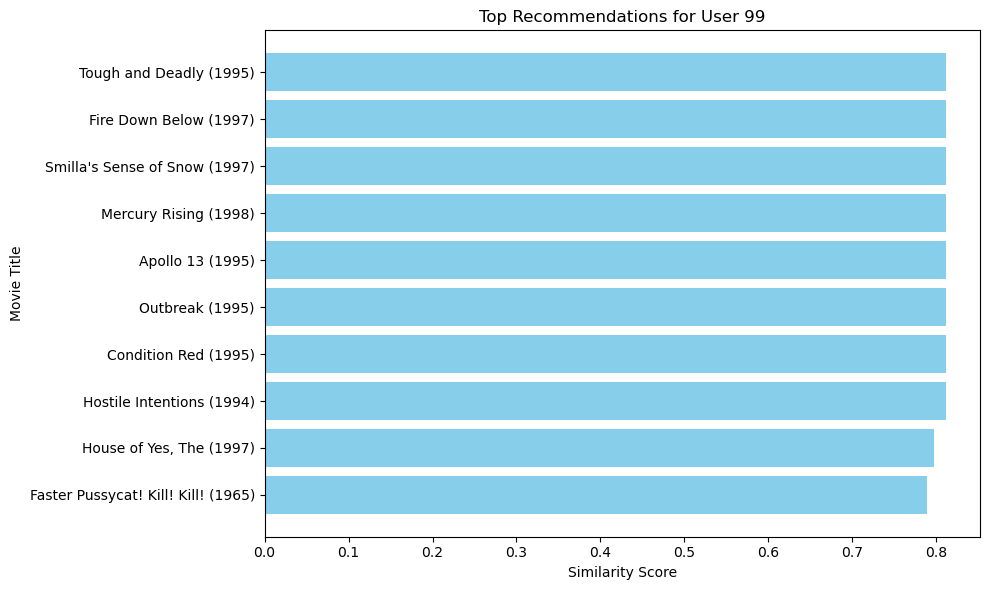

In [4]:
import matplotlib.pyplot as plt

def visualize_recommendations(recommendations, user_id):
    """
    Visualizes the top recommendations for a user as a horizontal bar chart.

    Args:
        recommendations (pd.DataFrame): DataFrame containing movie titles and similarity scores.
        user_id (int): User ID for whom the recommendations are generated.
    """
    plt.figure(figsize=(10, 6))
    plt.barh(recommendations['movie_title'], recommendations['similarity_score'], color='skyblue')
    plt.xlabel('Similarity Score')
    plt.ylabel('Movie Title')
    plt.title(f'Top Recommendations for User {user_id}')
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

# Example usage:
# Assuming `top_recommendations` is a DataFrame containing 'movie_title' and 'similarity_score' columns
visualize_recommendations(top_recommendations, user_id)

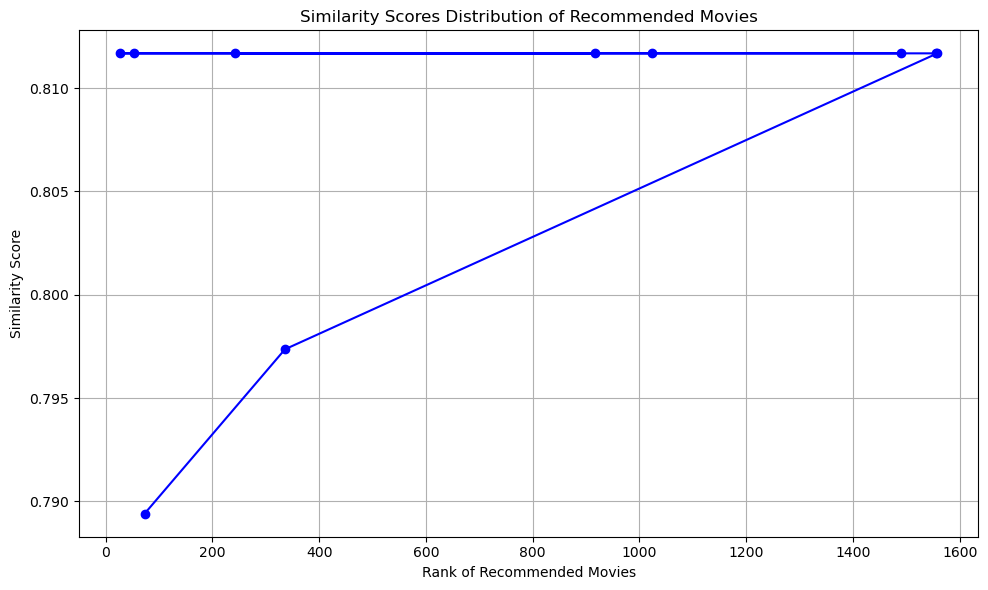

In [5]:
def plot_similarity_distribution(recommendations):
    """
    Plots the similarity score distribution of the recommended movies.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(recommendations['similarity_score'], marker='o', linestyle='-', color='b')
    plt.title("Similarity Scores Distribution of Recommended Movies")
    plt.xlabel("Rank of Recommended Movies")
    plt.ylabel("Similarity Score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
plot_similarity_distribution(top_recommendations)